# LSTM - 6 WEEK LATER SALE FORECASTING

In [15]:
# Importing Libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
# from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow
#import local libraries
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.data_loader import load_df_from_csv, optimize_df
from scripts.ML_modelling_utils import *
from scripts.data_information import DataInfo
from scripts.data_manipulation import DataManipulator


In [2]:
# Notebook settings
pd.set_option('max_column', None)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

## Loading Unclean Data

In [3]:
train_data = load_df_from_csv('../data/train.csv')
train_data = train_data[['Date','Sales']]
train_data = train_data.groupby('Date').agg({'Sales':'mean'})


C:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
# test_data = load_df_from_csv('../data/test.csv')
# test_data = test_data[['Date', 'Sales']]

Scaling Data

In [5]:
manipulator = DataManipulator(train_data, deep=True)

In [6]:
# Scaling all numeric values
manipulator.minmax_scale_columns(['Sales'], range_tup=(-1,1))

,Sales
Date,
2013-01-01,-1.00
2013-01-02,-0.12
2013-01-03,-0.19
2013-01-04,-0.16
2013-01-05,-0.25
...,...
2015-07-27,0.37
2015-07-28,0.16
2015-07-29,0.08


In [10]:
# After Scaling
scaled_data = optimize_df(manipulator.df)

## Time Series Analysis

### Isolate the Rossmann Store Sales dataset into time series data

In [11]:
# Group Unscaled Data based on Date
data = train_data


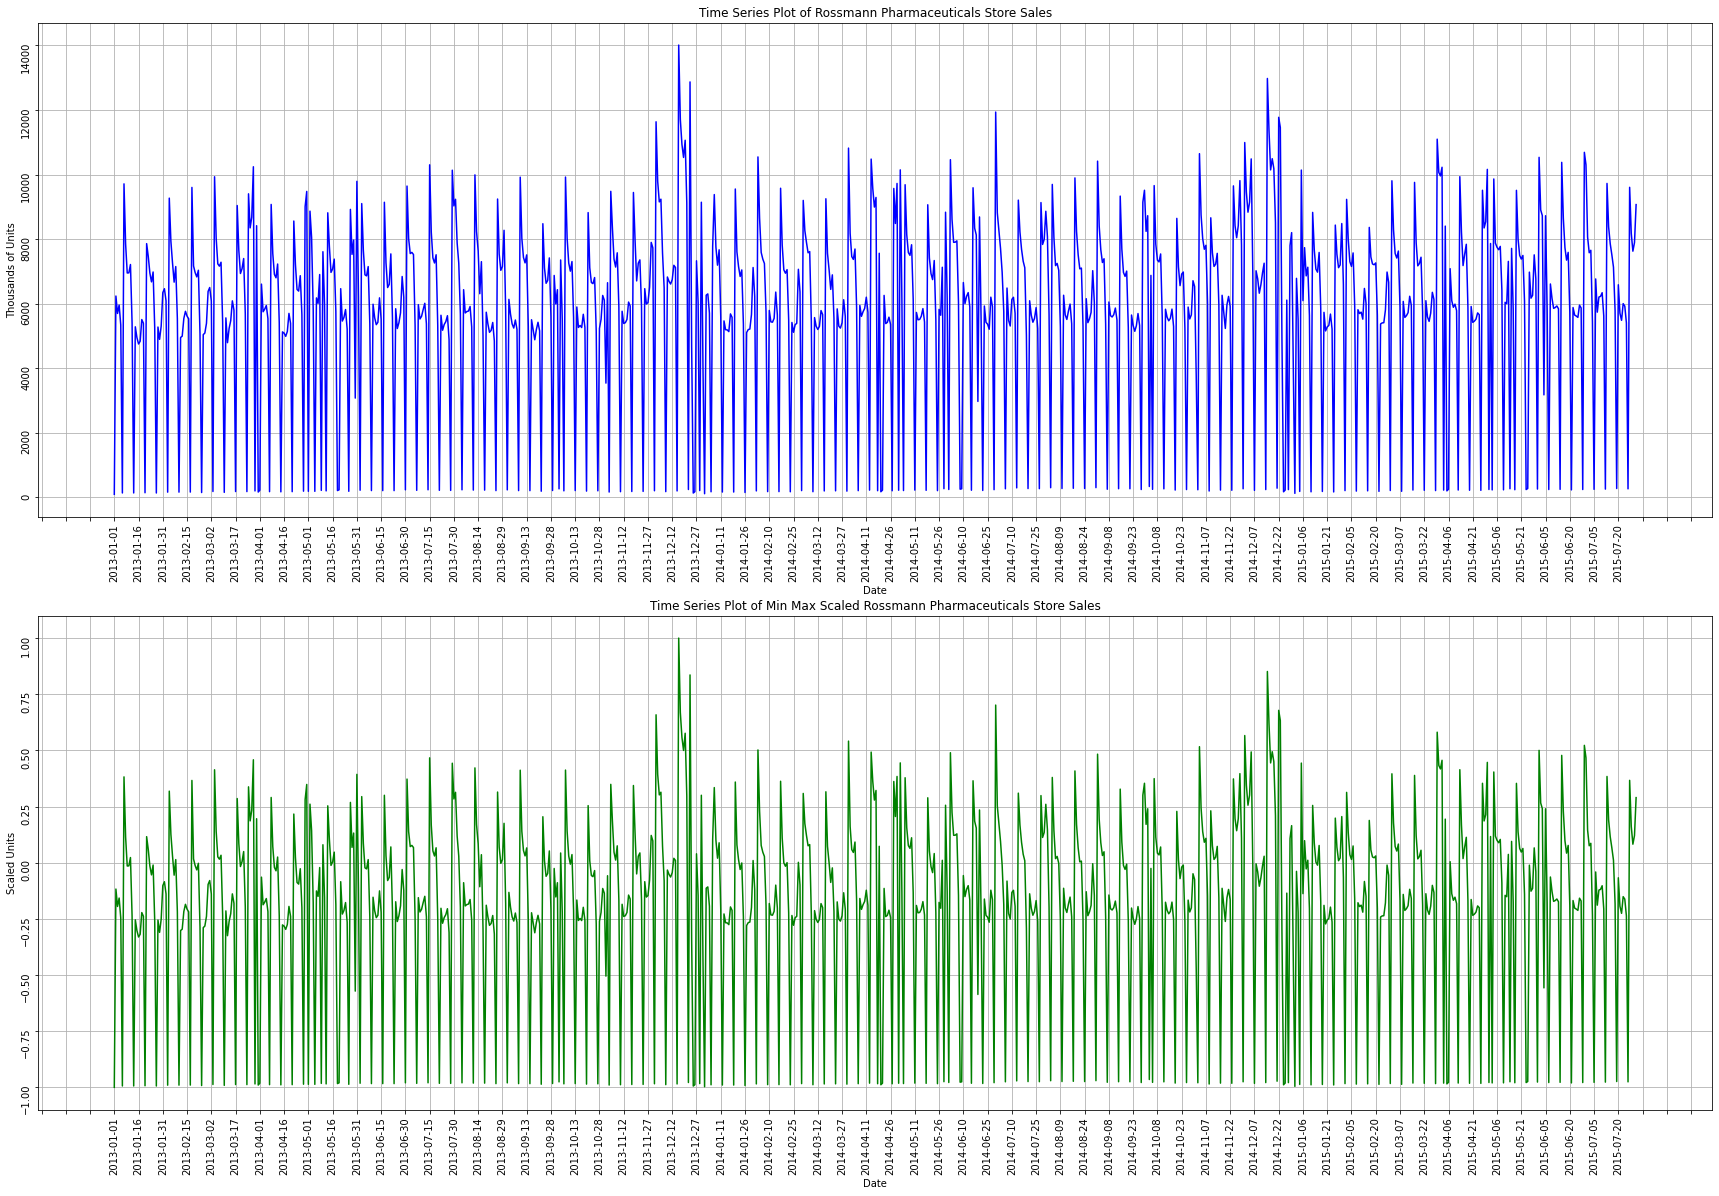

In [29]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(data.index, data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(scaled_data.index, scaled_data.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text(
    'Time Series Plot of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()


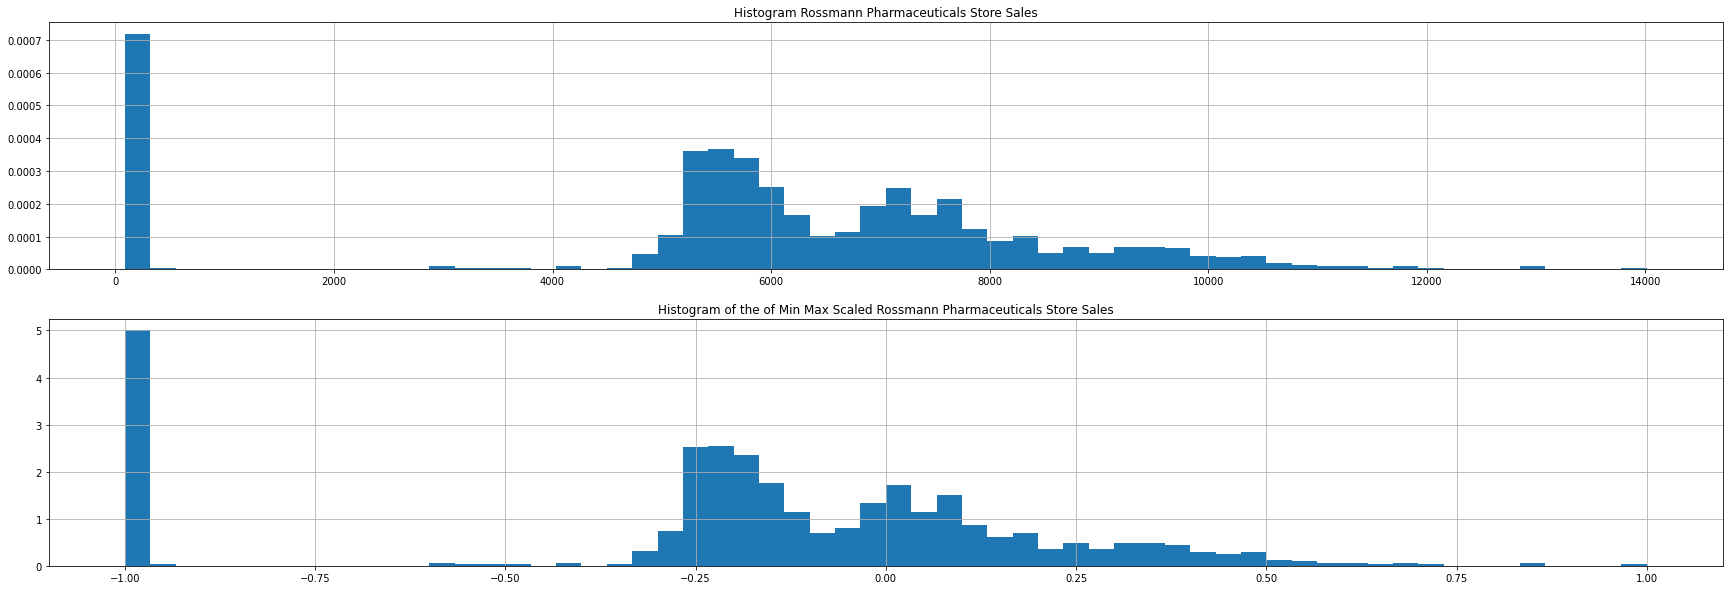

In [30]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(scaled_data.Sales, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()


### Check whether your time Series Data is Stationary

In [31]:
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   942 non-null    float32
dtypes: float32(1)
memory usage: 11.0+ KB


In [13]:
# hecking stationarity using unit root tests
# adfResult = adfuller(scaled_data.Sales.values, autolag='AIC')
# print(f'ADF Statistic: {adfResult[0]}')
# print(f'p-value: {adfResult[1]}')

### Depending on your conclusion from 2 above difference your time series data

In [14]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)


In [15]:
sales_difference = difference(scaled_data.Sales.values)


### Check for autocorrelation and partial autocorrelation of your data

In [32]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(
        f"{prefix}  Autocorrelations of Scaled Rossmann Pharmaceuticals Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()


In [33]:
# AutoCorrelation
acfSalesScaled = acf(scaled_data.Sales.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)


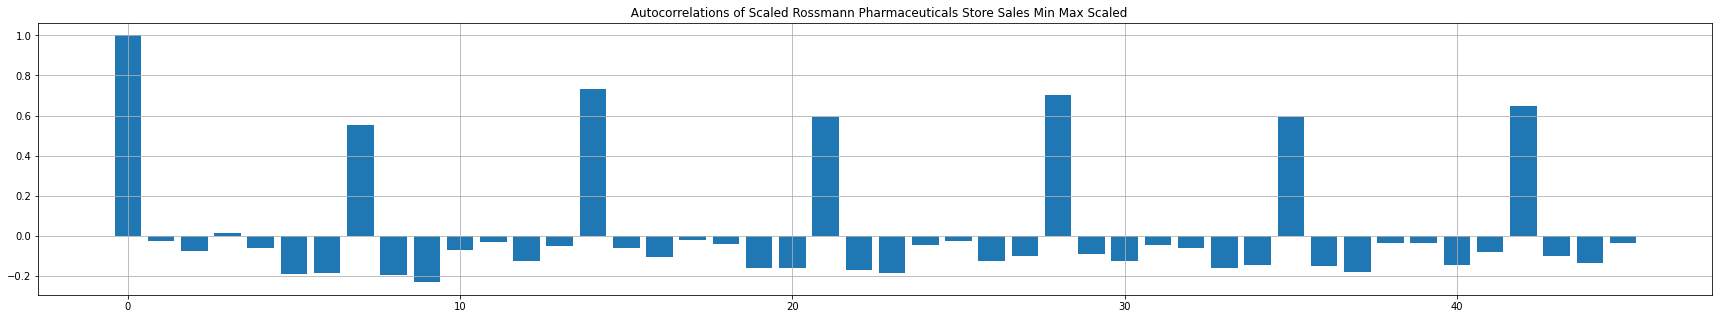

In [34]:
corrPlots(acfSalesScaledNp, '')


In [35]:
# Partial Correlation
pacfSalesScaled = pacf(scaled_data.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)


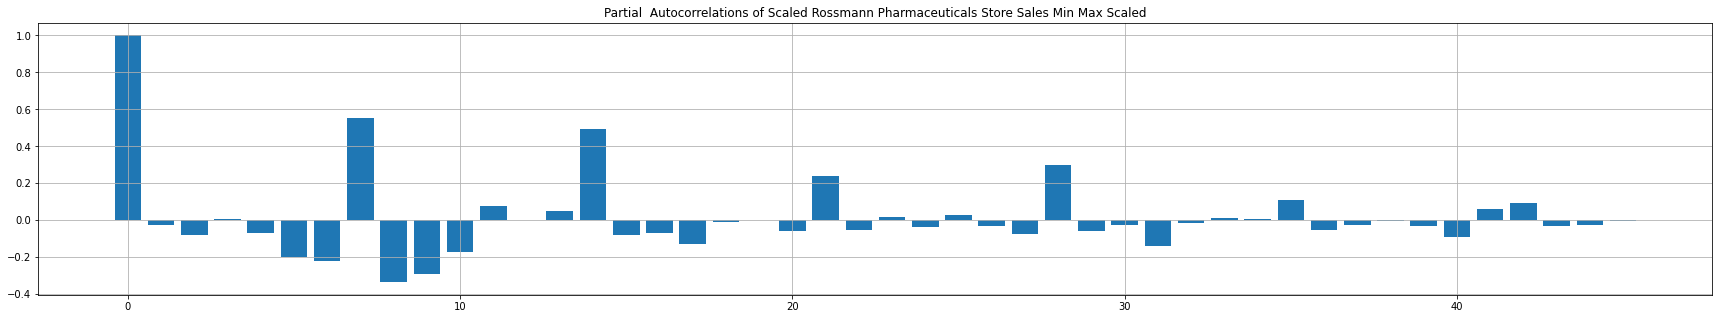

In [36]:
corrPlots(pacfSalesScaledNp, "Partial")


## Model Data Preparation

In [78]:
# Set window of past points for LSTM Model
# 6 Weeks is 45 Days (We have daily data of stores)
SIZE = len(scaled_data.Sales)
WINDOW_SIZE = 45
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 1000

In [65]:
# Spliting Data to Train and Test (80/20)
DateTrain = scaled_data.index.values[0:BATCH_SIZE]
DateValid = scaled_data.index.values[BATCH_SIZE:]
XTrain = scaled_data.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)


Shape of the training set date series:  (852, 1)
Shape of the validation set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [66]:
tf.random.set_seed(0)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape


TensorShape([852, 1])

In [67]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset


<TensorSliceDataset shapes: (1,), types: tf.float32>

In [68]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)


In [69]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))


In [70]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))


In [71]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)


In [72]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [73]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)


In [76]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')


In [79]:
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)


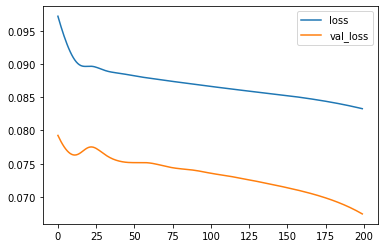

In [61]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()


In [62]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast


In [63]:
Forecast = model_forecast(
    model, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1, 1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1, 1))


NameError: name 'houseSales' is not defined

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(
    XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:, -1], rotation=90)
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(
    XValid1[:, -1], Results[:, -1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(
    XValid1[:, -1], Results[:, -1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()


In [ ]:
print(textstr)


## Data Preparation

In [13]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_data.Sales)/5.0)
Xtrain = scaled_data.Sales[:-last]
Xtest = scaled_data.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)


## Creating Model

In [16]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error')


## Training Model

In [19]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=500, batch_size=50, verbose=1)

Epoch 1/500
15/15 [==============================] - 0s 27ms/step - loss: 0.1176
Epoch 2/500
15/15 [==============================] - 0s 32ms/step - loss: 0.1157
Epoch 3/500
15/15 [==============================] - 1s 41ms/step - loss: 0.1133
Epoch 4/500
15/15 [==============================] - 0s 31ms/step - loss: 0.1145
Epoch 5/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1132
Epoch 6/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1134
Epoch 7/500
15/15 [==============================] - 0s 29ms/step - loss: 0.1047
Epoch 8/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1062
Epoch 9/500
15/15 [==============================] - 0s 29ms/step - loss: 0.1025
Epoch 10/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1064
Epoch 11/500
15/15 [==============================] - 0s 29ms/step - loss: 0.0994
Epoch 12/500
15/15 [==============================] - 0s 29ms/step - loss: 0.0979
Epoch 13/500
15/15 [=====

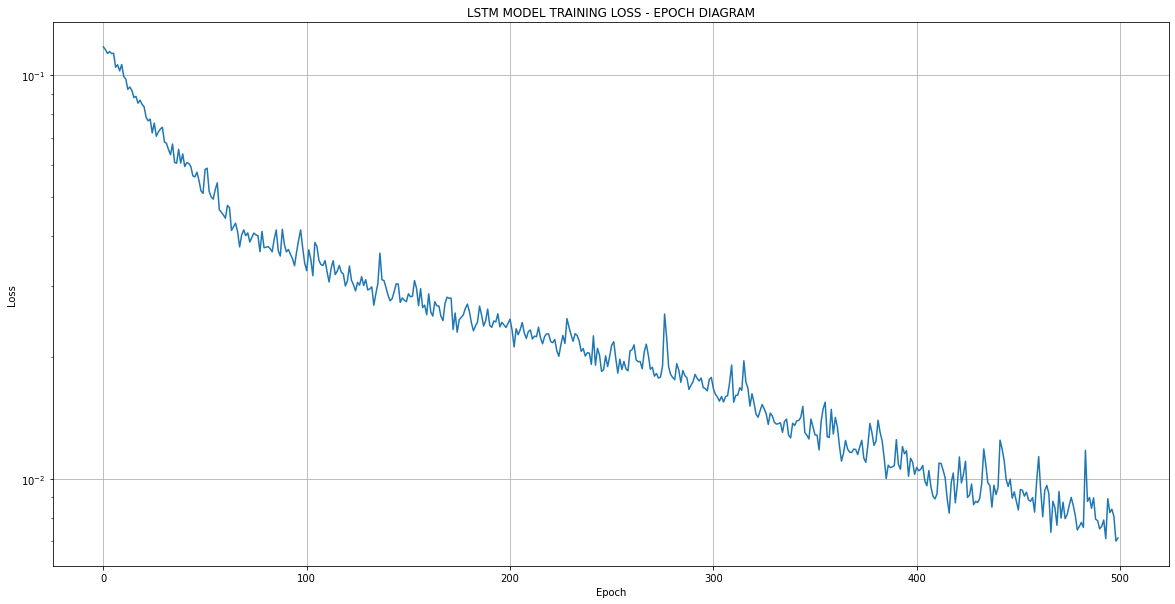

In [35]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])


## Prediction

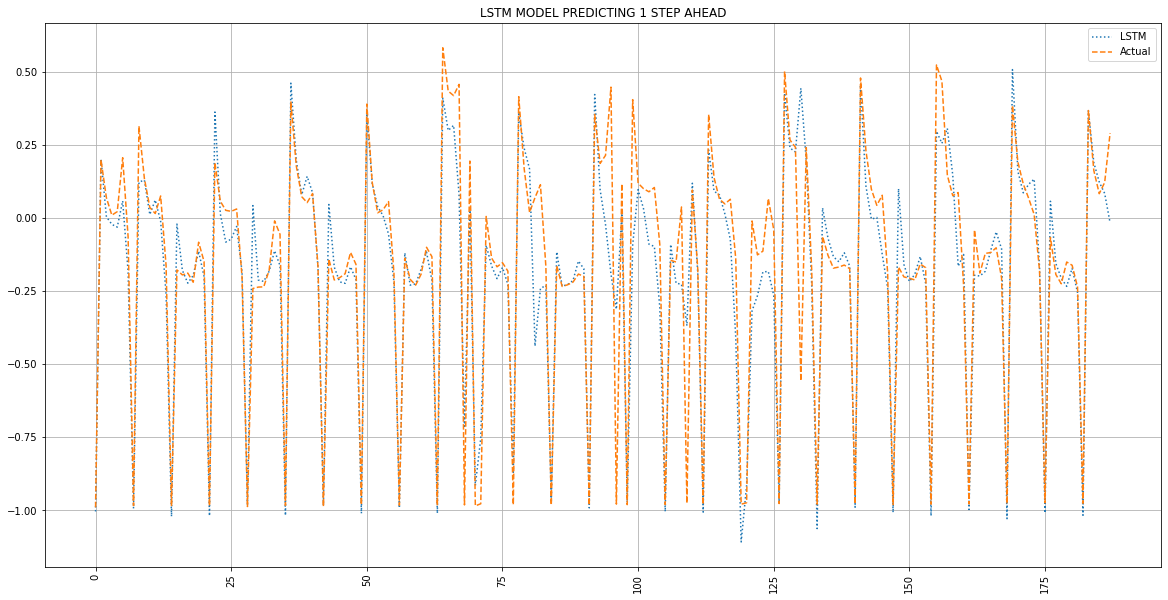

In [34]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()


## Validation

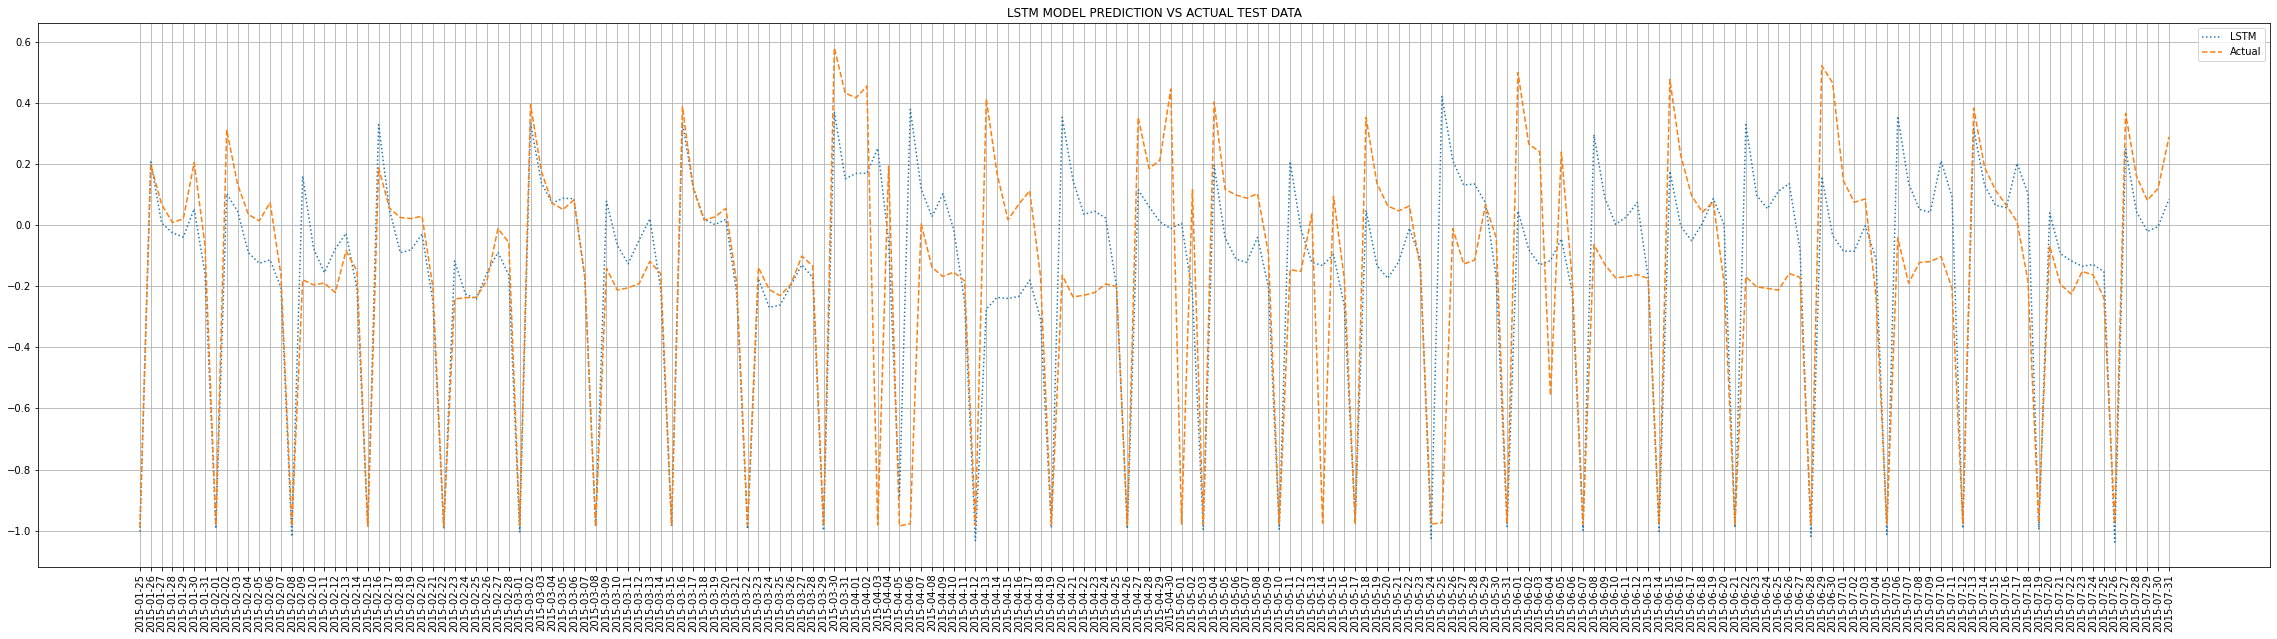

In [33]:
# Using predicted values to predict next step
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()
